In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bcnn_gal_171101 import *
import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
cifar = h5py.File('CIFAR10.h5', 'r')

random.seed(1337)

'''
perm1 = range(784)
perm2 = range(784)
perm3 = range(784)
perm4 = range(784)
perm5 = range(784)
perm6 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)
random.shuffle(perm3)
random.shuffle(perm4)
random.shuffle(perm5)
random.shuffle(perm6)

print perm1[0:20]
print perm2[0:20]

'''

x_train = list()
x_valid = list()
x_test = list()

x_train.append(cifar['train_imgs'][()])
'''
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
x_train.append(mnist['train_data'][()][:, perm3])
x_train.append(mnist['train_data'][()][:, perm4])
x_train.append(mnist['train_data'][()][:, perm5])
x_train.append(mnist['train_data'][()][:, perm6])
'''
t_train = num_to_onehot(cifar['train_labels'][()], 10)
x_valid.append(cifar['valid_imgs'][()])
'''
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
x_valid.append(mnist['valid_data'][()][:, perm3])
x_valid.append(mnist['valid_data'][()][:, perm4])
x_valid.append(mnist['valid_data'][()][:, perm5])
x_valid.append(mnist['valid_data'][()][:, perm6])
'''
t_valid = num_to_onehot(cifar['valid_labels'][()], 10)
x_test.append(cifar['test_imgs'][()])
'''
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
x_test.append(mnist['test_data'][()][:, perm3])
x_test.append(mnist['test_data'][()][:, perm4])
x_test.append(mnist['test_data'][()][:, perm5])
x_test.append(mnist['test_data'][()][:, perm6])
'''
t_test = num_to_onehot(cifar['test_labels'][()], 10)

cifar.close()


In [4]:
batch_size = 200

In [5]:
def print_accs(accs, ep):
    res = ""
    for acc in accs:
        res += " {:.4f}".format(acc[ep])
    
    print res

# Gal's BCNN

In [6]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [7]:
bcnn_gal = bcnn_gal_model([32, 32, 3], [[5, 5, 3, 32],[3, 3, 32, 64]], [True, True], [8 * 8 * 64, 100, 10], w_stdev = 0.1, n_samples = 10, \
                outact = tf.nn.relu, lr = 1e-3, l2_reg = True, l2_lambda = 0.1)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves_bcnn_gal/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


conv layer done
conv layer done
fc layer done
fc layer done
(?, 10)


In [10]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 1


valid_size = batch_size
n_split_valid = len(t_valid) / valid_size

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())

kp_numbers = [0.9, 0.9, 0.9, 0.9]
for d in range(1):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
#             feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
#                     bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
#                     bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5], \
#                     bcnn_gal.n_samples: 1}
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 32, 32, 3)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: kp_numbers}


            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.MCdropout(inp = np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 32, 32, 3)), \
                                                   tar = t_train[i*batch_size:(i+1)*batch_size], keep_probs = kp_numbers, \
                                                   n_samples = 40)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
                
        if ep == (n_epochs) - 1: epochs_done.append(ep)
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            valid_mean = 0.
            for j in range(n_split_valid):
                
                valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 32, 32, 3)), \
                                                tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = kp_numbers, \
                                                n_samples = 40)
                
            valid_mean /= n_split_valid
            vaccs_bcnn_gal[i].append(valid_mean)
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 32, 32, 3)), \
#                                                bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.1, 0.1, 0.1, 0.1]})
        #test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.105
ep 0, batch 50, training accuracy 0.14
ep 0, batch 100, training accuracy 0.09
ep 0, batch 150, training accuracy 0.085
ep 0, batch 200, training accuracy 0.205
valid accuracy: 0.20425
valid accuracy: 0.3365
valid accuracy: 0.392
valid accuracy: 0.421
valid accuracy: 0.432
valid accuracy: 0.4475
valid accuracy: 0.44425
valid accuracy: 0.458
valid accuracy: 0.451
valid accuracy: 0.47725
valid accuracy: 0.4665
valid accuracy: 0.505
valid accuracy: 0.493
valid accuracy: 0.51575
valid accuracy: 0.49325
valid accuracy: 0.492
valid accuracy: 0.5285
valid accuracy: 0.52825
valid accuracy: 0.52525
valid accuracy: 0.532
valid accuracy: 0.5245
valid accuracy: 0.5345
valid accuracy: 0.551
valid accuracy: 0.53825
valid accuracy: 0.545
valid accuracy: 0.549
valid accuracy: 0.55575
valid accuracy: 0.56825
valid accuracy: 0.56475
valid accuracy: 0.547
valid accuracy: 0.553
valid accuracy: 0.57825
valid accuracy: 0.55725
valid accuracy: 0.57875
valid accuracy: 0.

In [13]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7


valid_size = batch_size
n_split_valid = len(t_valid) / valid_size

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(n_datas):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
#             feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
#                     bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
#                     bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5], \
#                     bcnn_gal.n_samples: 1}
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}


            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.MCdropout(inp = np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                                                   tar = t_train[i*batch_size:(i+1)*batch_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                   n_samples = 10)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
                
        if ep == (n_epochs) - 1: epochs_done.append(ep)
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            valid_mean = 0.
            for j in range(n_split_valid):
                
                valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 28, 28, 1)), \
                                                tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = [0.5, 0.5, 0.5, 0.5], \
                                                n_samples = 10)
                
            valid_mean /= n_split_valid
            vaccs_bcnn_gal[i].append(valid_mean)
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                               bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.105
ep 0, batch 50, training accuracy 0.82
ep 0, batch 100, training accuracy 0.83
ep 0, batch 150, training accuracy 0.9
ep 0, batch 200, training accuracy 0.94
valid accuracy: 0.9332 0.0963 0.0967 0.1102 0.0939 0.0933 0.0743
valid accuracy: 0.9547 0.1049 0.0927 0.1203 0.0985 0.1107 0.0708
valid accuracy: 0.9372 0.1046 0.1038 0.117 0.1055 0.1038 0.0864
valid accuracy: 0.9703 0.1151 0.1018 0.1219 0.1046 0.1052 0.0805
valid accuracy: 0.9724 0.1173 0.1083 0.1165 0.1076 0.116 0.0851
valid accuracy: 0.9768 0.1113 0.1027 0.1179 0.1141 0.1205 0.0885
valid accuracy: 0.9784 0.1109 0.1086 0.1165 0.1076 0.1254 0.0858
valid accuracy: 0.9808 0.1173 0.106 0.1158 0.1139 0.1217 0.1001
valid accuracy: 0.9784 0.1127 0.1043 0.1199 0.1147 0.1245 0.0931
valid accuracy: 0.9812 0.0995 0.1021 0.1181 0.1108 0.1256 0.0959
valid accuracy: 0.9831 0.1104 0.1051 0.1052 0.1119 0.1233 0.0926
valid accuracy: 0.9827 0.107 0.1084 0.1177 0.108 0.1331 0.0945
valid accuracy: 0.9858 0.112

In [17]:
vaccs_bcnn_gal_add = list()
for i in range(n_datas):
    vaccs_bcnn_gal_add.append(list())

for i in range(n_datas): 
    valid_mean = 0.
    for j in range(n_split_valid):

        valid_mean += bcnn_gal.MCdropout(inp = np.reshape(x_valid[i][j*valid_size:(j+1)*valid_size], (-1, 32, 32, 3)), \
                                        tar =  t_valid[j*valid_size:(j+1)*valid_size], keep_probs = [0.9, 0.9, 0.9, 0.9], \
                                        n_samples = 100)

    valid_mean /= n_split_valid
    vaccs_bcnn_gal_add[i].append(valid_mean)
    str_vacc += " {:.5g}".format(vaccs_bcnn_gal_add[i][-1])
    
print str_vacc

valid accuracy: 0.61125 0.6045 0.6045 0.56875 0.614 0.61425


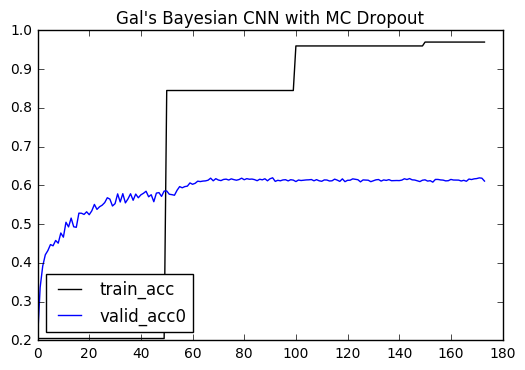

In [11]:
plt.title('Gal\'s Bayesian CNN with MC Dropout')
plt.plot(taccs_bcnn_gal, 'k')
plt.plot(vaccs_bcnn_gal[0], 'b')
'''
plt.plot(vaccs_bcnn_gal[1], 'g')
plt.plot(vaccs_bcnn_gal[2], 'r')
plt.plot(vaccs_bcnn_gal[3], 'c')
plt.plot(vaccs_bcnn_gal[4], 'b')
plt.plot(vaccs_bcnn_gal[5], 'g')
plt.plot(vaccs_bcnn_gal[6], 'r')
'''
#plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.legend(['train_acc', 'valid_acc0'],loc = 3)
plt.show()

# Blundell version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

# train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
# test_writer = tf.train.SummaryWriter(savedir + 'test')

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())
    
for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        bnn.reset_klrw()

        for i in range(n_batches):
            
            bnn.decay_klrw()

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
                
            bnn.train(feed)

        fs_mean.append(np.mean(fs[-n_batches:]))

        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))




In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.title('Blundell\'s Bayesian NN')
plt.plot(taccs, 'k')
plt.plot(vaccs[0], 'tab:blue')
plt.plot(vaccs[1], 'tab:orange')
plt.plot(vaccs[2], 'tab:green')
plt.plot(vaccs[3], 'tab:red')
plt.plot(vaccs[4], 'tab:purple')
plt.plot(vaccs[5], 'tab:brown')
plt.plot(vaccs[6], 'tab:pink')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Online version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_OL = taccs
vaccs_BNN_OL = vaccs

plt.title('Bayesian NN')

plt.plot(taccs_BNN_OL, 'k')
plt.plot(vaccs_BNN_OL[0], 'b')
plt.plot(vaccs_BNN_OL[1], 'g')
plt.plot(vaccs_BNN_OL[2], 'r')
plt.plot(vaccs_BNN_OL[3], 'c')
plt.plot(vaccs_BNN_OL[4], 'b')
plt.plot(vaccs_BNN_OL[5], 'g')
plt.plot(vaccs_BNN_OL[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_OL, 0)
print_accs(vaccs_BNN_OL, 199)
print_accs(vaccs_BNN_OL, 399)
print_accs(vaccs_BNN_OL, 599)
print_accs(vaccs_BNN_OL, 799)
print_accs(vaccs_BNN_OL, 999)
print_accs(vaccs_BNN_OL, 1199)
print_accs(vaccs_BNN_OL, 1399)

# Online version + EWC with rho_grad

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
print bnn.p_params

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

# Normal NN

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    nn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')

plt.plot(taccs_nNN, 'k')
plt.plot(vaccs_nNN[0], 'b')
plt.plot(vaccs_nNN[1], 'g')
plt.plot(vaccs_nNN[2], 'r')
plt.plot(vaccs_nNN[3], 'c')
plt.plot(vaccs_nNN[4], 'b')
plt.plot(vaccs_nNN[5], 'g')
plt.plot(vaccs_nNN[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_nNN, 0)
print_accs(vaccs_nNN, 1999)
print_accs(vaccs_nNN, 3999)
print_accs(vaccs_nNN, 5999)
print_accs(vaccs_nNN, 7999)
print_accs(vaccs_nNN, 9999)
print_accs(vaccs_nNN, 11999)
print_accs(vaccs_nNN, 13999)

# Normal NN + EWC

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3

                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    enn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)